In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import sklearn as sk

In [284]:
df=pd.read_csv('amazon_sales_dataset.csv')
df.head()

,order_id,order_date,ship_date,delivery_date,order_status,customer_id,customer_name,country,state,city,...,product_name,category,sub_category,brand,quantity,unit_price,discount,shipping_cost,total_sales,payment_method
0,A10000,2026-01-31,2026-01-31,2026-01-08,Delivered,C5691,Ricky Potter,India,South Carolina,New Joe,...,without,Home,Furniture,Doyle-Jordan,3,42467.79,0.26,60.85,94339.3438,Card
1,A10001,2026-01-20,2026-02-03,2026-02-03,Delivered,C9811,Chris Davenport,India,Tennessee,Madisonmouth,...,school,Home,Furniture,Davis LLC,2,36138.76,0.24,112.96,55043.8752,COD
2,A10002,2026-01-15,2026-02-07,2026-01-03,Delivered,C7341,Timothy Gallagher,India,Iowa,East Larryberg,...,I,Electronics,Laptop,Watson and Sons,4,47148.93,0.14,64.11,162256.4292,UPI
3,A10003,2026-01-18,2026-01-15,2026-01-20,Delivered,C4012,Angela Collins,India,Kentucky,South Margaretshire,...,step,Electronics,Laptop,"Sandoval, Buckley and Solis",1,18487.99,0.06,114.15,17492.8606,Card
4,A10004,2026-01-27,2026-01-04,2026-01-23,Delivered,C1328,David Davidson DDS,India,North Dakota,Velasquezview,...,bit,Home,Kitchen,"Key, Bautista and Bowen",1,1742.25,0.10,40.47,1608.4950,UPI


### Descriptive Statistical Analysis
Summary of key metrics (mean, standard deviation, quartiles) to evaluate data distribution and identify potential anomalies or outliers.

In [285]:
df.describe()

,quantity,unit_price,discount,shipping_cost,total_sales
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.01440,25126.511133,0.149968,85.053192,64212.910555
std,1.42035,14343.922332,0.086828,37.575284,50992.635082
min,1.00000,214.200000,0.000000,20.010000,309.939600
25%,2.00000,12657.827500,0.070000,52.507500,24037.196775
50%,3.00000,24880.490000,0.150000,84.995000,50287.177500
75%,4.00000,37544.640000,0.220000,117.680000,93417.891825
max,5.00000,49981.880000,0.300000,149.950000,249155.530000


### Feature Engineering and Datetime Processing
Cleaning the dataset by removing unnecessary columns, converting date fields to datetime objects, and deriving new temporal features such as shipping and delivery durations.

In [286]:
df=df.drop(columns=['order_id','order_status','customer_name', 'brand','country','product_name'])
df['order_date']=pd.to_datetime(df['order_date'])
df['ship_date']=pd.to_datetime(df['ship_date'])
df['delivery_date']=pd.to_datetime(df['delivery_date'])

df['order_month']=df['order_date'].dt.month
print(df['order_month'].unique())
df['order_day']=df['order_date'].dt.day

df['time_to_start_shipping']=(df['ship_date']-df['order_date']).dt.days
df['time_to_ship']=(df['delivery_date'] - df['ship_date']).dt.days
df['time_to_arrive']=(df['delivery_date']-df['order_date']).dt.days

df=df.sort_values("order_date")
mask=((df['time_to_start_shipping'] >= 0) & ( df['time_to_ship'] >= 0))


[1 2]


### Total Sales Distribution
Visualization of the `total_sales` distribution using a histogram to understand the frequency and spread of transaction values.

array([[<Axes: title={'center': 'total_sales'}>]], dtype=object)

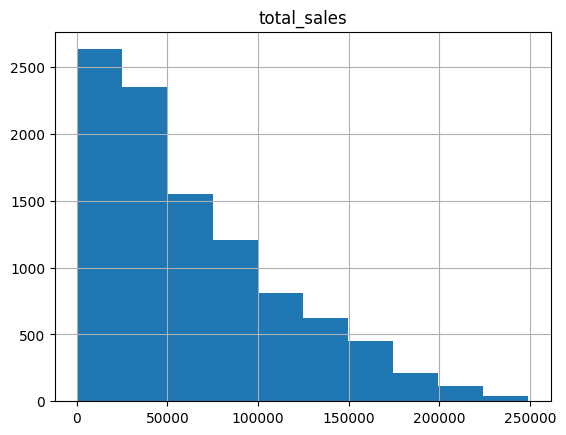

In [287]:
df.hist(column='total_sales', bins=10)

### Log-Normal Distribution Fitting and Visualization
Fitting a log-normal distribution to the `total_sales` data and visualizing the log-transformed distribution with a KDE plot to assess the model fit. 

76916808.6915457


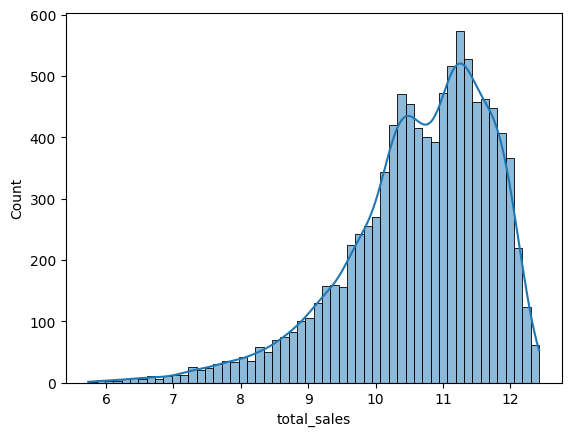

In [288]:
from scipy import stats


shape, loc, scale = stats.lognorm.fit(df["total_sales"], floc=0)
sns.histplot(np.log(df["total_sales"]), kde=True)
next_1000_sales=np.sum(stats.lognorm.rvs(shape, loc=0, scale=scale, size=1000, random_state=42))
print(next_1000_sales)


### Pareto Analysis of Revenue by City
Identification of the top 20% of cities and calculation of their contribution to total revenue, accompanied by a cumulative sales distribution plot to visualize market concentration.

The top 20% of cities are responsible for the 48.88% of total revenue
count      7647.000000
mean      83971.375121
std       78386.499121
min         309.939600
25%       28025.729200
50%       63261.700000
75%      119526.017550
max      806828.242100
Name: total_sales, dtype: float64


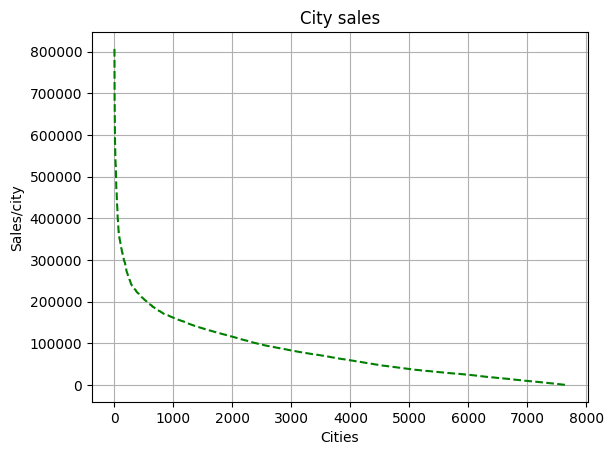

In [289]:
#to search how to the top 20% spend their money
t_sales=df['total_sales'].groupby(df['city']).sum().sort_values(ascending=False)

top_20_idx= int(len(t_sales) * 0.20)
share=round((t_sales.iloc[:top_20_idx].sum() / t_sales.sum()) * 100,2)
print(f'The top 20% of cities are responsible for the {share}% of total revenue')

fig, ax = plt.subplots()
ax.plot(np.arange(len(t_sales)),t_sales, color='green', linestyle='--')
ax.set_title('City sales')
ax.set_ylabel('Sales/city')
ax.set_xlabel('Cities')
ax.grid()
print(t_sales.describe())


### Weekly Sales Distribution
Aggregating total sales by day of the week to identify patterns in consumer spending behavior and determine peak sales days.

Text(0.5, 1.0, 'Total spending per day')

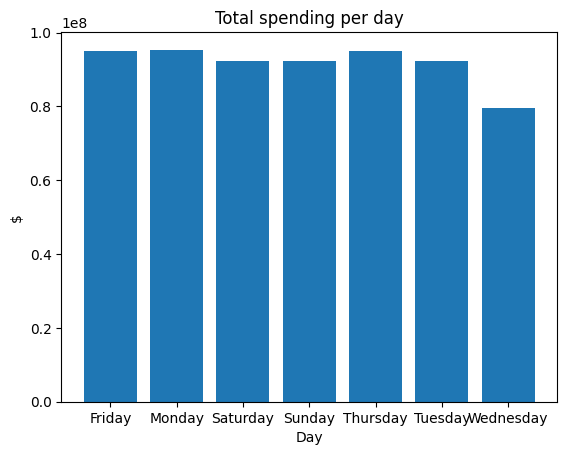

In [290]:
avg_sale_day=df['total_sales'].groupby(df['order_date'].dt.day_name()).sum()
plt.bar(avg_sale_day.index, avg_sale_day)
plt.ylabel('$')
plt.xlabel('Day')
plt.title('Total spending per day')


### Product Category Distribution in Top-Performing Cities
Analysis of sales by sub-category within the top 20% of cities by revenue, visualized through a pie chart to identify dominant product segments in high-value markets.

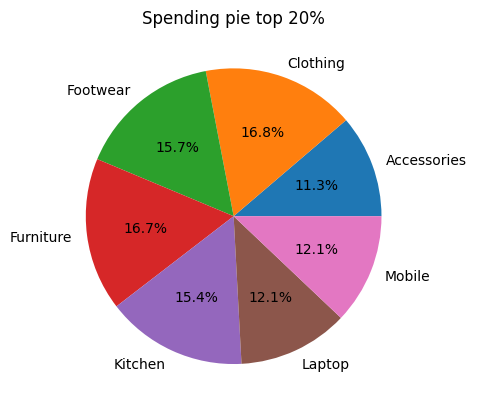

In [291]:
mask=df['city'].isin(t_sales.iloc[:top_20_idx].index)

category_sales_top_20=df['total_sales'][mask].groupby(df['sub_category'][mask]).sum()
fig, ax = plt.subplots()
ax.pie(category_sales_top_20, labels=category_sales_top_20.index, autopct='%1.1f%%')
plt.title('Spending pie top 20%')
plt.show()


### Total Sales Distribution by Sub-Category
Aggregating total revenue by product sub-category and visualizing the proportion of spending across different segments using a pie chart.

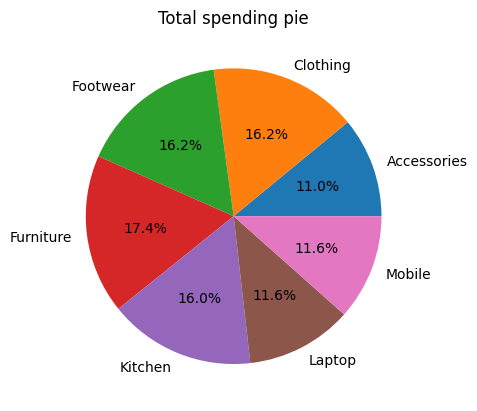

In [292]:
category_sales=df['total_sales'].groupby(df['sub_category']).sum()
fig, ax = plt.subplots()
ax.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%')
plt.title('Total spending pie')
plt.show()

### Label Encoding and Categorical Transformation
Converting categorical variables—including geographical data, IDs, and product classifications—into numerical codes to prepare the dataset for machine learning algorithms and statistical modeling.

In [293]:

states=dict(enumerate(df['state'].astype('category').cat.categories))
df["state"] = df["state"].astype("category").cat.codes


df["customer_id"] = df["customer_id"].astype("category").cat.codes
df["product_id"] = df["product_id"].astype("category").cat.codes
df["category"] = df["category"].astype("category").cat.codes
df["sub_category"] = df["sub_category"].astype("category").cat.codes
df["payment_method"] = df["payment_method"].astype("category").cat.codes
df["city"] = df["city"].astype("category").cat.codes

df.head()
#df=df[mask]

,order_date,ship_date,delivery_date,customer_id,state,city,product_id,category,sub_category,quantity,unit_price,discount,shipping_cost,total_sales,payment_method,order_month,order_day,time_to_start_shipping,time_to_ship,time_to_arrive
217,2026-01-01,2026-01-08,2026-01-25,76,0,2440,345,0,6,1,17984.59,0.10,97.17,16283.3010,1,1,1,7,17,24
173,2026-01-01,2026-01-03,2026-01-28,288,44,3385,159,1,2,2,44566.05,0.23,129.81,68761.5270,1,1,1,2,25,27
349,2026-01-01,2026-01-13,2026-01-17,3415,22,6395,406,0,0,3,49193.65,0.29,45.07,104827.5445,1,1,1,12,4,16
2389,2026-01-01,2026-01-17,2026-01-31,4421,11,4703,330,0,6,2,1480.64,0.10,49.53,2714.6820,1,1,1,16,14,30
7893,2026-01-01,2026-01-26,2026-02-03,4428,8,4169,594,1,1,5,3156.05,0.29,51.77,11255.7475,0,1,1,25,8,33


<Axes: >

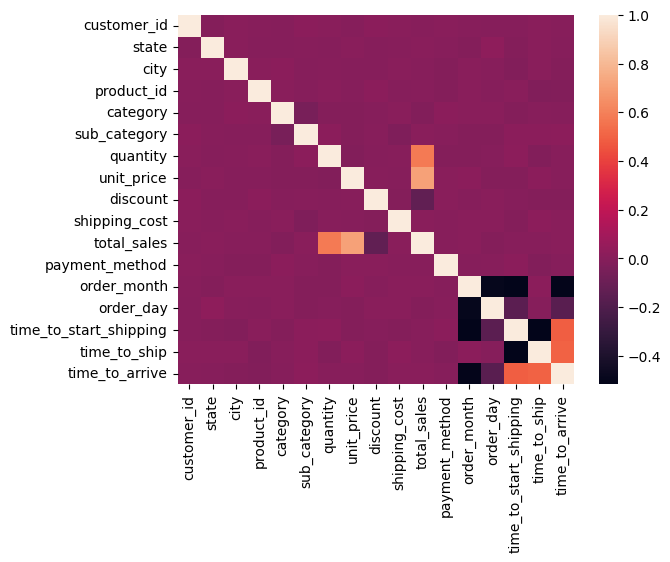

In [294]:
sns.heatmap(df.iloc[:,3:].corr())

### Customer Spending Distribution
Aggregating total sales by unique customer IDs and visualizing the distribution of individual spending patterns using a scatter plot to identify high-value customers and spending variance.

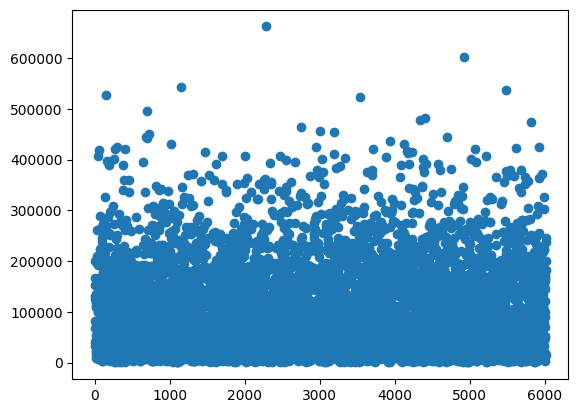

In [295]:
total_spent_per_user=df['total_sales'].groupby(df['customer_id']).sum()
plt.scatter(total_spent_per_user.index,total_spent_per_user)

### Optimal Cluster Selection (Silhouette Method)
Evaluating the optimal number of clusters for customer segmentation by calculating and plotting the Silhouette Score for a range of $k$ values to determine the best model fit.

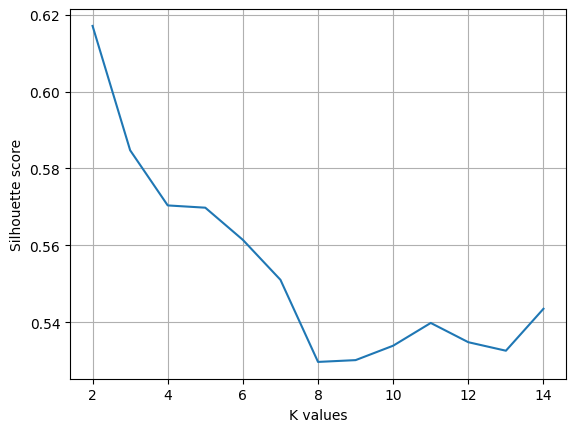

In [296]:
scores=[]
for k in range(2,15):
    kmeans=sk.cluster.KMeans(n_clusters=k).fit_predict(total_spent_per_user.to_numpy().reshape(-1,1))
    score=sk.metrics.silhouette_score(total_spent_per_user.to_numpy().reshape(-1,1), kmeans)
    scores.append(score)

fig, ax = plt.subplots()

ax.plot(np.arange(len(scores))+2,scores)
ax.set_xlabel('K values')
ax.set_ylabel('Silhouette score')
ax.grid()

### K-Means Customer Segmentation
Applying the K-Means clustering algorithm with the optimal number of clusters ($k=2$) to segment customers based on their total spending, visualized with a scatter plot to distinguish between different spending tiers.

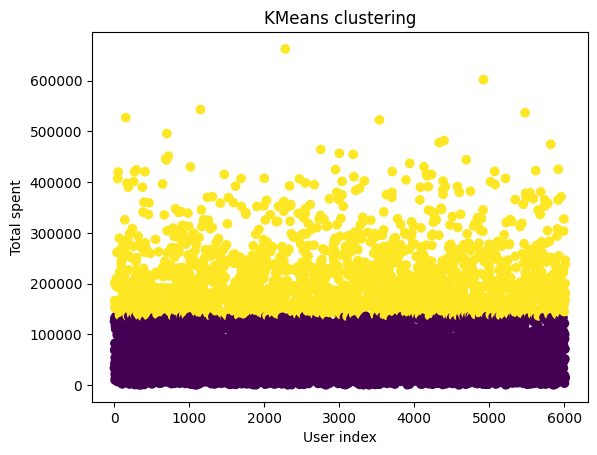

In [297]:
labels=sk.cluster.KMeans(n_clusters=2, random_state=10).fit_predict(total_spent_per_user.to_numpy().reshape(-1,1))


plt.scatter(total_spent_per_user.index,total_spent_per_user,c=labels,cmap='viridis')

plt.xlabel("User index")
plt.ylabel("Total spent")
plt.title("KMeans clustering")
plt.show()


### Revenue Contribution by Customer Cluster
Calculating the share of total revenue generated by each customer segment to quantify the financial impact of different user groups.

In [298]:

total_spent_per_user['label']=labels
total_spent_per_cluster=total_spent_per_user['total_sales'].groupby(total_spent_per_user['label']).sum()
for i,t in enumerate(total_spent_per_cluster):
  print(f"Cluster {i} accounts for {t/total_spent_per_cluster.sum()} of total spending")



KeyError: 'total_sales'

In [ ]:
df.to_csv('to_normalize.csv')